In [ ]:
def create_frame(t, t0, Forecast, my_prediction):
    plt.figure(figsize=(20,10))
    plt.title('t = '+str(t)+' days')
    tt = np.arange(t0,t)
    plt.plot(tt, new_pos_tot[tt], linewidth=1.5, alpha=0.7, label='data')
    plt.plot(tt, my_prediction[tt-t0], linewidth=1.5, color='red', label='prediction')
    plt.grid(True)
    for i in range(Forecast.n):
        plt.plot(tt,Forecast.single_predict(i,tt), label=f'wave {i}', linewidth=1.2)
    plt.legend(fontsize=18, loc=2)
    ax = plt.gca()
    ax.set_facecolor('whitesmoke')
    plt.savefig(f'./img/dat_{t}.png')
    plt.close()

In [29]:
# Using the forecast as a class updated

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import Forecast as fc
import imageio

gif_Flag = False
# gif_Flag = True
if gif_Flag:
    frames_dat = []

national_data=pd.read_csv('..\data\dati-andamento-nazionale\dpc-covid19-ita-andamento-nazionale.csv')
new_pos_tot=national_data['nuovi_positivi'].values[:]
cum_pos_tot=np.cumsum(new_pos_tot)
t0=14
T=new_pos_tot.shape[0]
tt_forecast = np.arange(t0,T)
rt_list = []

my_prediction = np.zeros(T-t0)

Forecast = fc.n_waves(new_pos_tot,window=7)
fit_data = np.zeros(T)
for t in tt_forecast:
    fit_data[t] = Forecast.daily_update()
    rt_list.append(Forecast.rt)
    my_prediction[t-t0] = Forecast.predict(t+1)
    if gif_Flag:
        create_frame(t, t0, Forecast, my_prediction)
        image_dat = imageio.v2.imread(f'./img/dat_{t}.png')
        frames_dat.append(image_dat)
    
        

c:\Users\adria\OneDrive - Politecnico di Milano\adriano\politecnico\Mathematical Engineering\Advanced Mathematical Modelling\Projects\Wave\script\Forecast.py:29: RuntimeWarning: divide by zero encountered in log
  log_data = np.log(data)
c:\Users\adria\OneDrive - Politecnico di Milano\adriano\politecnico\Mathematical Engineering\Advanced Mathematical Modelling\Projects\Wave\script\Forecast.py:32: RuntimeWarning: invalid value encountered in scalar subtract
  rt[i] = log_data[i+1]-log_data[i]


In [30]:
if gif_Flag:
    imageio.mimsave('./dat_avg.gif', # output gif
                    frames_dat,          # array of input frames
                    fps = 10,         # optional: frames per second
                    loop=1)     
    print('GIF saved')

Text(0, 0.5, 'rt')

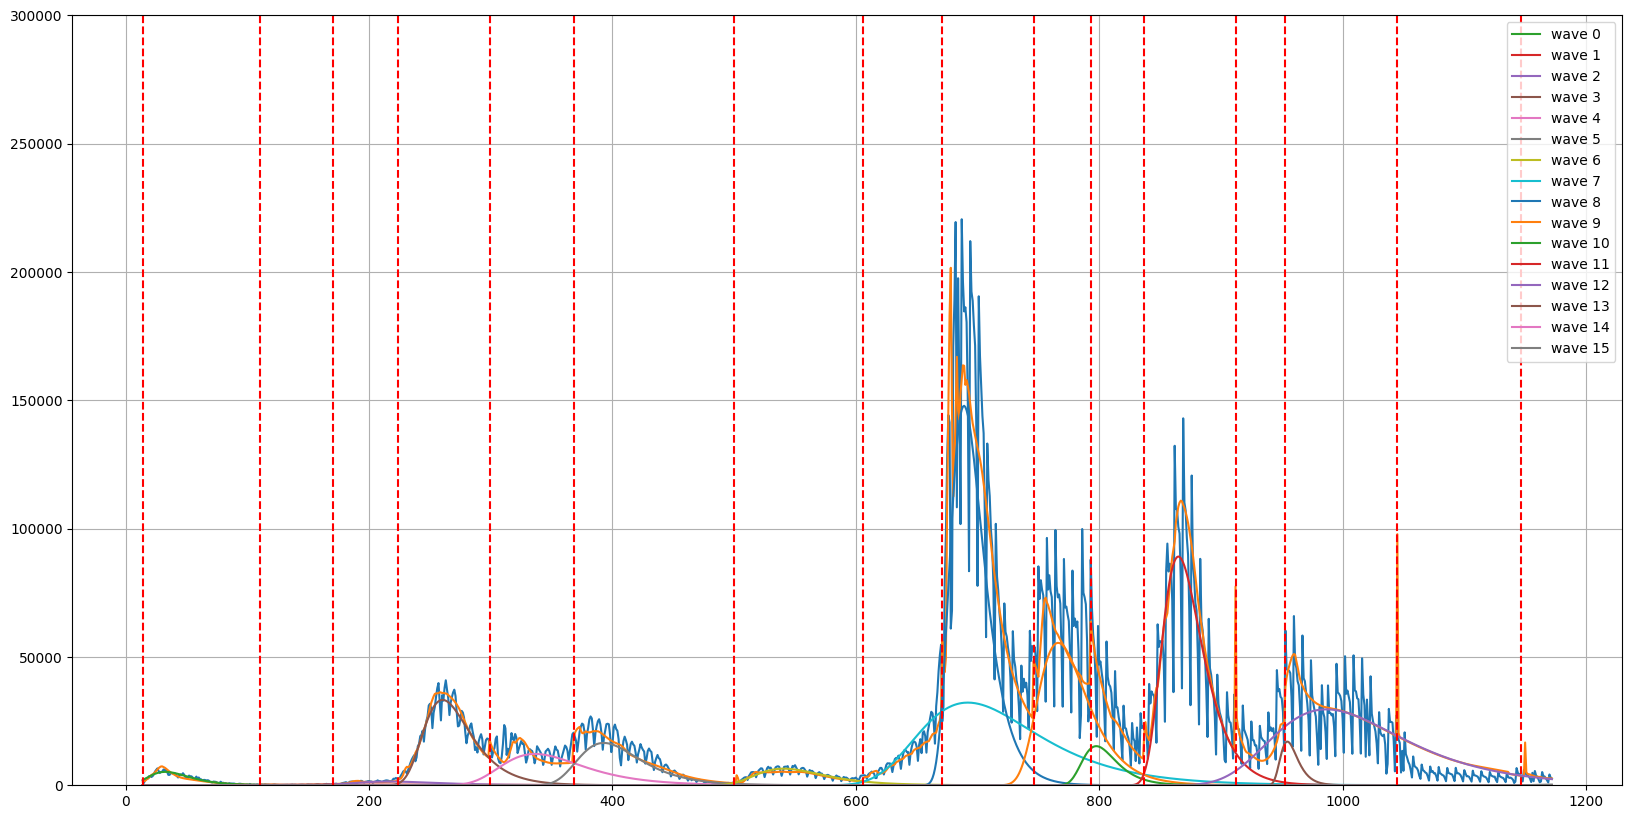

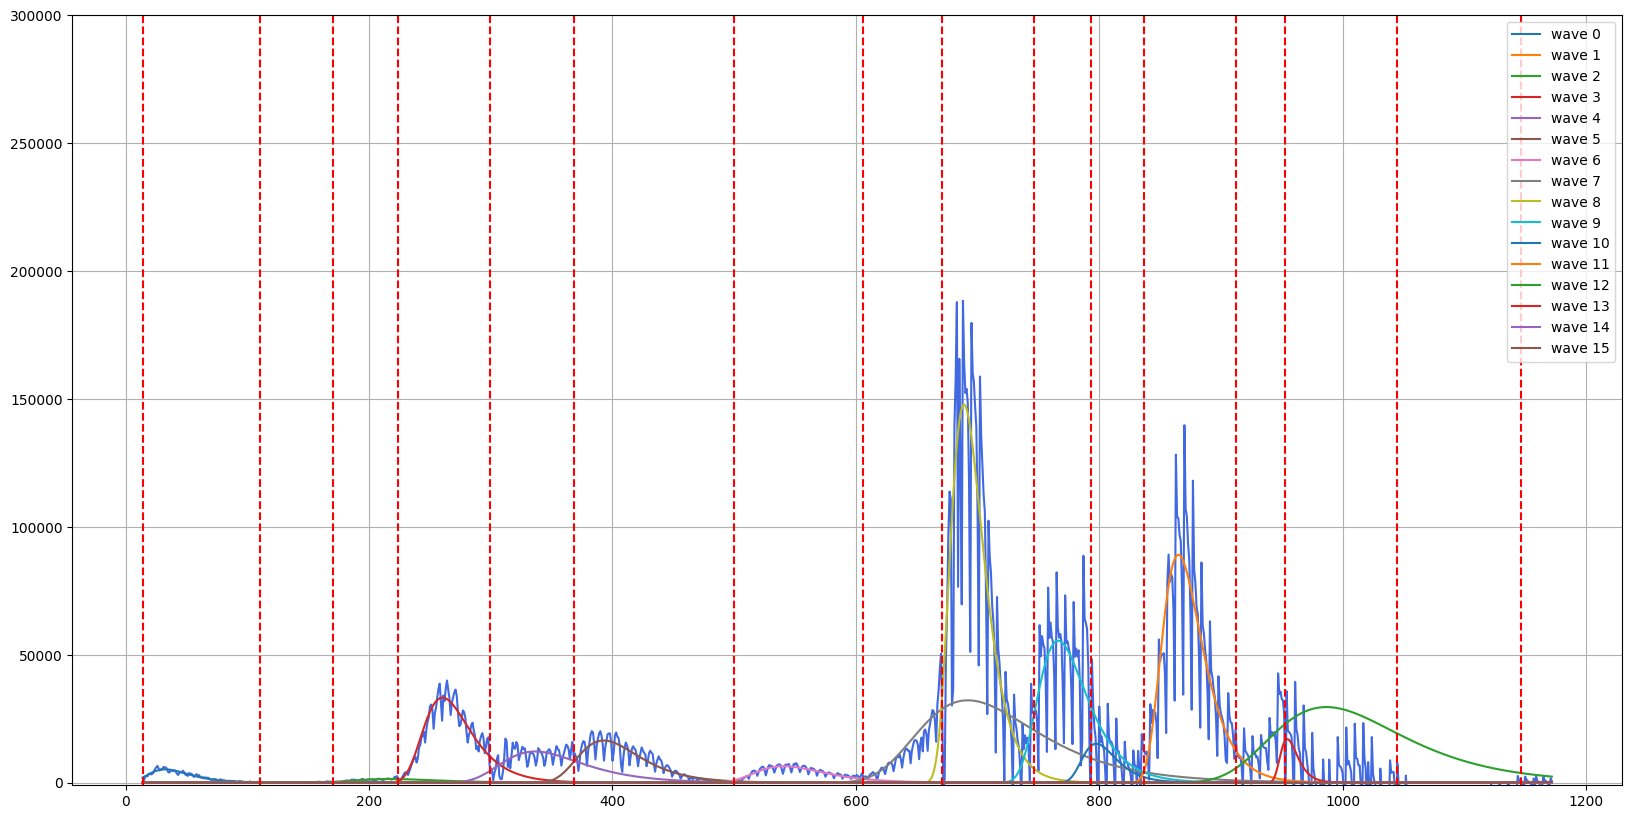

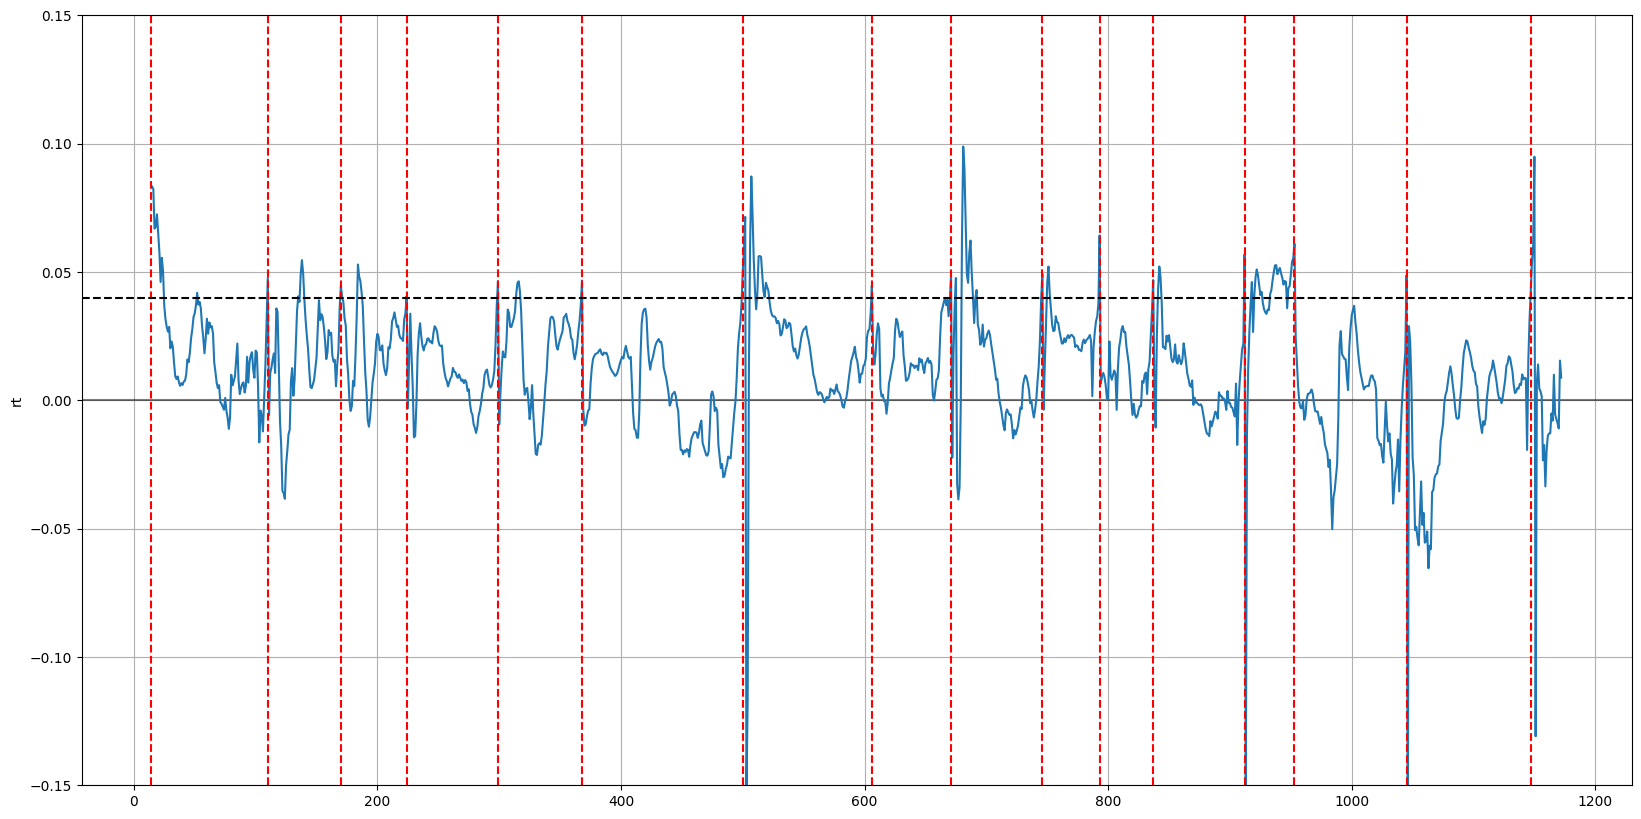

In [31]:
plt.figure(figsize=(20,10))
plt.plot(tt_forecast, new_pos_tot[tt_forecast])
plt.plot(tt_forecast, my_prediction[tt_forecast-t0])
plt.grid(True)
tt = np.arange(t0,T)
for i in range(Forecast.n):
    plt.plot(tt,Forecast.single_predict(i,tt), label=f'wave {i}')
for i in range(len(Forecast.L_starts)):
    plt.axvline(Forecast.L_starts[i], color='r', linestyle='--')
plt.legend()
plt.ylim(0,300000)

plt.figure(figsize=(20,10))
plt.plot(tt_forecast, fit_data[tt_forecast], color='royalblue')
plt.grid(True)
tt = np.arange(t0,T)
for i in range(Forecast.n):
    plt.plot(tt,Forecast.single_predict(i,tt), label=f'wave {i}')
for i in range(len(Forecast.L_starts)):
    plt.axvline(Forecast.L_starts[i], color='r', linestyle='--')
plt.legend()
plt.ylim(-1000,300000)

plt.figure(figsize=(20,10))
plt.axhline(0, color='k', linestyle='-', alpha=0.5)
plt.plot(tt_forecast,rt_list)
plt.grid(True)
for i in range(len(Forecast.L_starts)):
    plt.axvline(Forecast.L_starts[i], color='r', linestyle='--')
plt.axhline(0.04, color='k', linestyle='--')
plt.ylim(-0.15,0.15)
plt.ylabel('rt')


In [32]:
for i in range(Forecast.n):
    print(f'----------------------------Wave {i}------------------------------')
    Forecast.L_waves[i].params.pretty_print()

----------------------------Wave 0------------------------------
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
K         35.96        5      100    0.421     True     None     None
b         7.063        1      100    0.195     True     None     None
c       0.06021     -inf      inf 0.0008471    False log(b)/t_max     None
t_max     32.47       15      100    0.226     True     None     None
----------------------------Wave 1------------------------------
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
K           100        5      100    37.64     True     None     None
b         3.627        1      100   0.1692     True     None     None
c       0.01373     -inf      inf 0.003082    False log(b)/t_max     None
t_max     93.86       15      100    22.38     True     None     None
----------------------------Wave 2------------------------------
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
K          51.1     

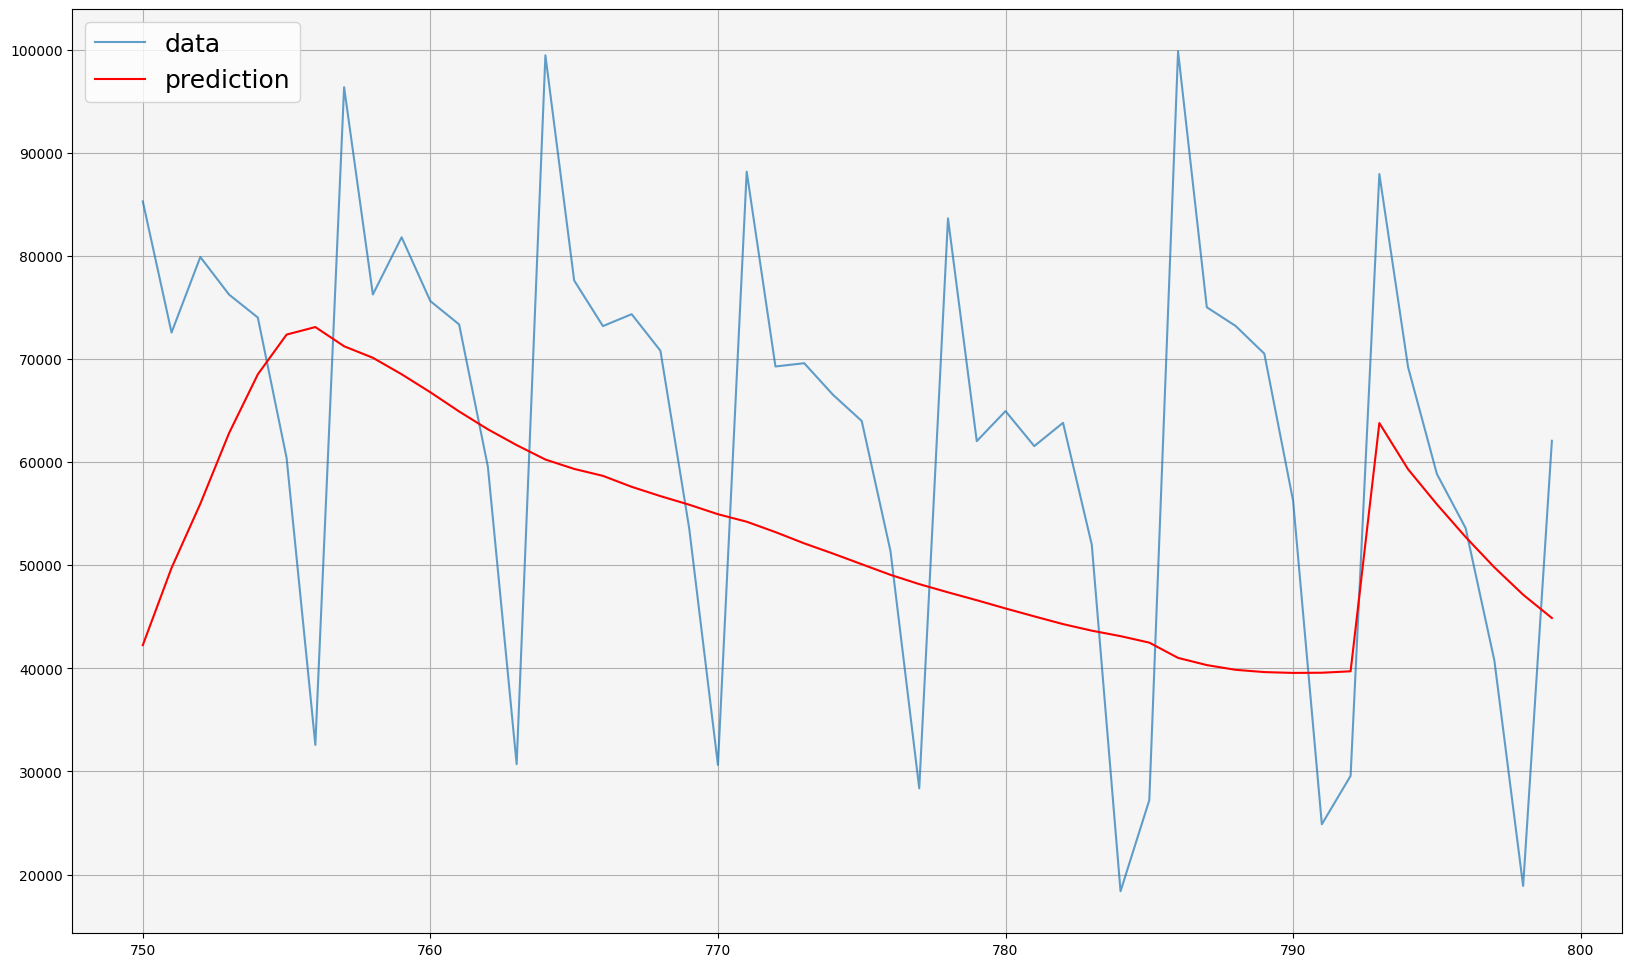

In [33]:
plt.figure(figsize=(20,12))
plt.plot(tt_forecast[750:800]-14, new_pos_tot[tt_forecast[750:800]-14], linewidth=1.5, alpha=0.7, label='data')
plt.plot(tt_forecast[750:800]-14, my_prediction[tt_forecast[750:800]-14-t0], linewidth=1.5, color='red', label='prediction')
plt.grid(True)
tt = np.arange(t0,T)
#for i in range(Forecast.n):
    #plt.plot(tt[750:800]-14,Forecast.single_predict(i,tt[750:800]), label=f'wave {i}', linewidth=1.2)
plt.legend(fontsize=18, loc=2)
ax = plt.gca()
ax.set_facecolor('whitesmoke')
